In [4]:
#!pip install statsmodels

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import scipy.stats as stats
import statsmodels.api as sm

In [30]:
#df = pd.read_csv('D:\GitHub\MSc-Project\SWaT DataSWaT 2015-12-23.csv')

df = pd.read_csv('/home/loz/MSc/MSc_Project/SWaT DataSWaT 2015-12-23.csv')

In [31]:
!nvcc --version

/bin/bash: line 1: nvcc: command not found


In [71]:
df.head()

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,date,time
0,2015-12-23 00:00:00,0.0,0.994030,0.5,1.0,0.0,0.509983,0.197627,0.500754,0.769136,...,0.0,0.958717,0.279476,0.962447,0.0,0.0,0.0,0.0,2015-12-23,00:00:00
1,2015-12-23 00:00:01,0.0,0.993523,0.5,1.0,0.0,0.509983,0.197627,0.501658,0.863706,...,0.0,0.958466,0.279476,0.962447,0.0,0.0,0.0,0.0,2015-12-23,00:00:01
2,2015-12-23 00:00:02,0.0,0.993523,0.5,1.0,0.0,0.509983,0.197627,0.503767,0.916761,...,0.0,0.957840,0.279476,0.962366,0.0,0.0,0.0,0.0,2015-12-23,00:00:02
3,2015-12-23 00:00:03,0.0,0.993467,0.5,1.0,0.0,0.494624,0.194993,0.506178,0.952045,...,0.0,0.957840,0.279476,0.961636,0.0,0.0,0.0,0.0,2015-12-23,00:00:03
4,2015-12-23 00:00:04,0.0,0.993072,0.5,1.0,0.0,0.494624,0.194993,0.509593,0.974452,...,0.0,0.958654,0.279476,0.961636,0.0,0.0,0.0,0.0,2015-12-23,00:00:04


In [73]:
def doFourierAnalysis(df, column_name):
    """
    Performs Fourier analysis on named column in the passed DataFrame, plots the power spectrum against the frequency bins.

    The plot is displayed on logarithmic scaled axis.

    Parameters:
    df (pandas.DataFrame): Sensor values DataFrame.
    column_name (str): The name of the column to analyze.

    Returns:
    None
    """
    # Extract the data from the DataFrame
    data = df[column_name].values

    # Number of data points
    N = len(data)

    # Compute the Fast Fourier Transform (FFT)
    fft_data = np.fft.fft(data)

    # Compute the Power Spectrum (magnitude of the FFT squared)
    power_spectrum = np.abs(fft_data) ** 2

    # Compute the frequency bins
    # If you have a time step dt between data points, replace 1.0 with dt in the line below
    freq = np.fft.fftfreq(N, 10.0)

    return (freq, power_spectrum)

def performFourierAndLimitHarmonics(df, column_name, num_harmonics):

    data = df[column_name].values

    # Perform the Fast Fourier Transform (FFT)
    fft_data = np.fft.fft(data)
    N = len(data)

    # Compute the magnitude of the FFT and find the indices of the largest components
    magnitudes = np.abs(fft_data)
    indices = np.argsort(magnitudes)[::-1]  # Sort indices by magnitude in descending order

    # Zero out all but the largest `num_harmonics` components
    fft_data_limited = np.zeros(N, dtype=complex)
    for i in range(num_harmonics):
        index = indices[i]
        fft_data_limited[index] = fft_data[index]

    # Inverse FFT to reconstruct the signal with limited harmonics
    reconstructed_signal = np.fft.ifft(fft_data_limited)

    return reconstructed_signal, fft_data_limited




In [74]:
def plot_columns(df, columns_list):

    # Convert the 'time' column to datetime if it's not already in that format
    if df['time'].dtype == object:
        df['time'] = pd.to_datetime(df['time'])

    # Set the size of the plot
    plt.figure(figsize=(12, 6))

    # Loop through the columns and plot each one
    for column in columns_list:
        plt.plot(df['time'], df[column], label=column)

    # Add title and labels
    plt.title('Signals Over Time')
    plt.xlabel('Time')
    plt.yscale('log')
    plt.ylabel('Signal Value')

    # set y range to plot if passed
    plt.ylim( 0.1, 1)

    # Show legend
    plt.legend()

    # Show grid
    plt.grid(True)

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()


In [75]:
def prep_data(df: pd.DataFrame, columns_list: list, start_time: str= None, end_time: str= None) -> pd.DataFrame:
    '''
    :param df: df of scaled results for a single date
    :param columns_list: columns to keep includingtime column
    :param start_time: string in format 'hh:mm:ss', default takes min value in df
    :param end_time: string in format 'hh:mm:ss', default takes max value in df
    :return: df of only values in time windo for specified columns
    '''

    # get times if not passed
    if start_time is None:
        start_time = df['time'].min()
    #else:
    #    start_time = pd.to_datetime(start_time)
    #    print(type(start_time))
    if end_time is None:
        end_time = df['time'].max()
    #else:
    #    end_time = pd.to_datetime(end_time)

    # filter to rows in time window
    df = df[(df['time'] >= start_time) & (df['time'] <= end_time)]
    df = df[columns_list]
    df_prepped = df.copy()

    # replace low values possibly to tidy graph

    return df_prepped


In [76]:
columns_list = ['time', 'MV101','LIT101','FIT101','P101','FIT201','MV201']

In [77]:
df_prepped = prep_data(df, columns_list, start_time= '00:00:00', end_time= '08:00:00')

In [78]:
columns_to_plot = ['MV101','LIT101','FIT101','P101','FIT201','MV201']

In [79]:
df_prepped.head()
# df.columns

,time,MV101,LIT101,FIT101,P101,FIT201,MV201
0,00:00:00,0.5,0.994030,0.0,1.0,0.769136,1.0
1,00:00:01,0.5,0.993523,0.0,1.0,0.863706,1.0
2,00:00:02,0.5,0.993523,0.0,1.0,0.916761,1.0
3,00:00:03,0.5,0.993467,0.0,1.0,0.952045,1.0
4,00:00:04,0.5,0.993072,0.0,1.0,0.974452,1.0


In [80]:
#df.head()

/tmp/ipykernel_47408/2298128413.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['time'] = pd.to_datetime(df['time'])


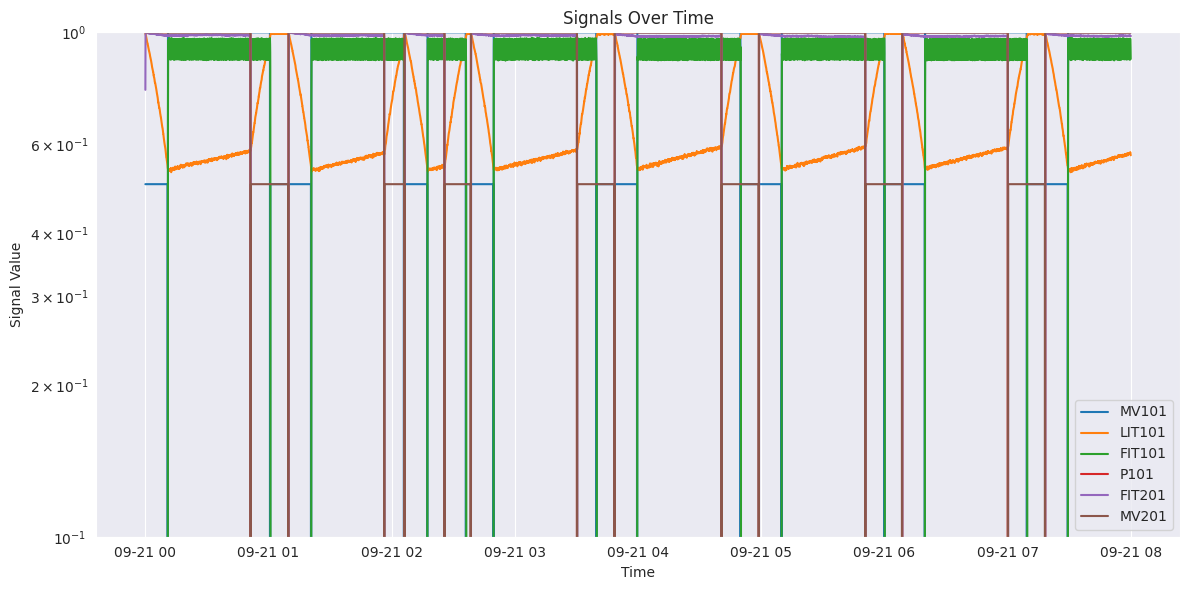

In [81]:
plot_columns(df_prepped, columns_to_plot)

NameError: name 'column_name' is not defined

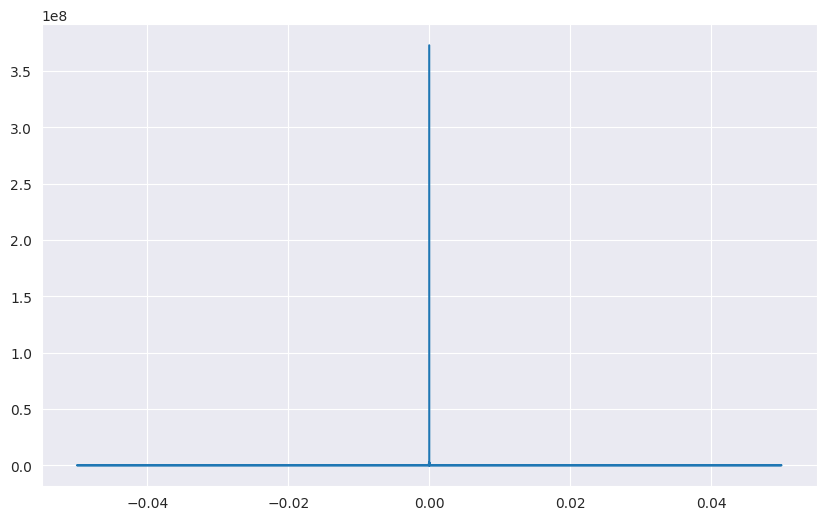

In [82]:
freq, power_spectrum = doFourierAnalysis(df_prepped, 'LIT101')

# Plotting the Power Spectrum
plt.figure(figsize=(10, 6))
plt.plot(freq, power_spectrum)
plt.title(f'{column_name} Power Spectrum')
plt.xscale('log')
plt.xlabel('Frequency')
plt.yscale('log')
plt.ylabel('Power')
plt.xlim(0, np.max(freq))  # Limit x-axis to non-negative frequencies
plt.show()

/tmp/ipykernel_47408/4143436321.py:14: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, np.max(freq_lit101))  # Limit x-axis to non-negative frequencies


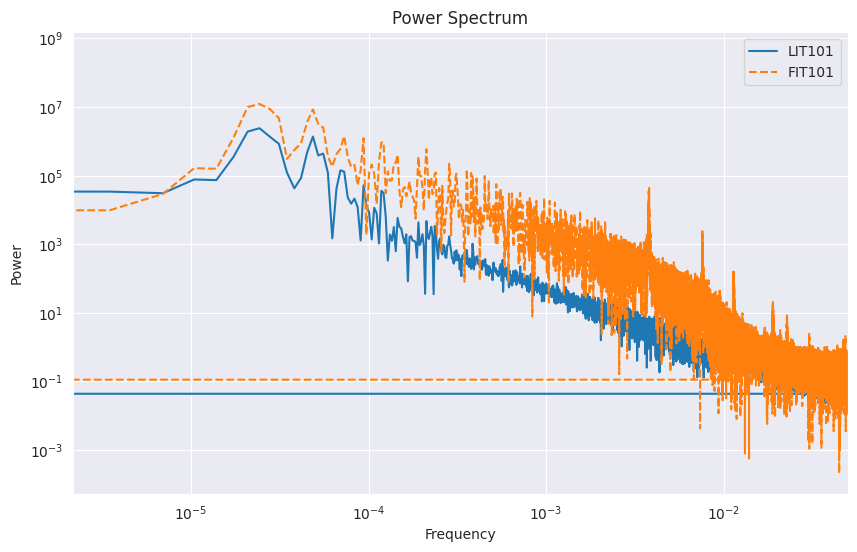

In [83]:
# Assuming df_prepped is already defined and contains 'LIT101' and 'FIT101' columns
freq_lit101, power_spectrum_lit101 = doFourierAnalysis(df_prepped, 'LIT101')
freq_fit101, power_spectrum_fit101 = doFourierAnalysis(df_prepped, 'FIT101')

# Plotting the Power Spectrum for both 'LIT101' and 'FIT101'
plt.figure(figsize=(10, 6))
plt.plot(freq_lit101, power_spectrum_lit101, label='LIT101')
plt.plot(freq_fit101, power_spectrum_fit101, label='FIT101', linestyle='--')
plt.title('Power Spectrum')
plt.xscale('log')
plt.xlabel('Frequency')
plt.yscale('log')
plt.ylabel('Power')
plt.xlim(0, np.max(freq_lit101))  # Limit x-axis to non-negative frequencies
plt.legend()
plt.show()

In [84]:
#  Function to find the fundamental frequency
def find_fundamental_frequency(freq, power_spectrum):
    # Peaks in the power spectrum
    peaks, _ = find_peaks(power_spectrum)
    
    # Fundamental frequency (the first peak)
    if peaks.size > 0:
        fundamental_freq = freq[peaks[0]]  # The first peak corresponds to the fundamental frequency
        return fundamental_freq
    else:
        return None




/tmp/ipykernel_47408/3661709188.py:27: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, np.max(freq_lit101))


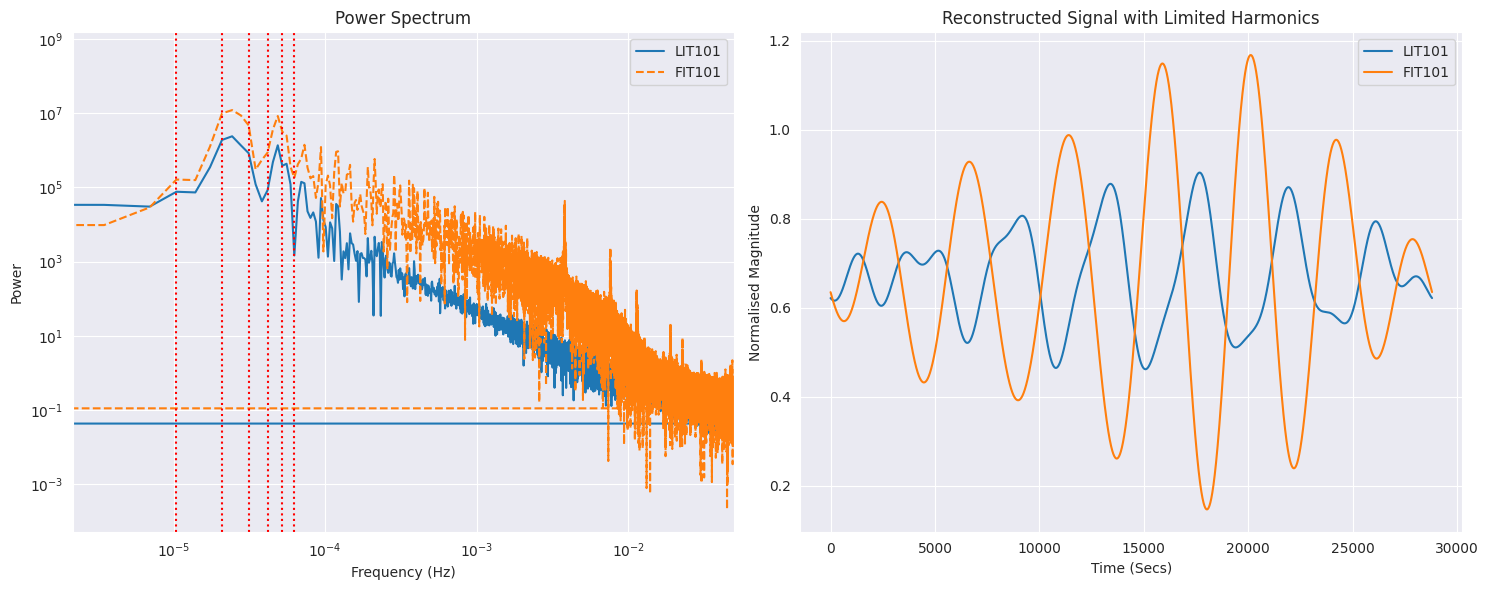

In [99]:

# Plot original and reconstructed signals
plt.figure(figsize=(15, 6))

# Original Signal
plt.subplot(1, 2, 1)
plt.title('Power Spectrum')

# Get freqs and power spectrum
freq_lit101, power_spectrum_lit101 = doFourierAnalysis(df_prepped, 'LIT101')
freq_fit101, power_spectrum_fit101 = doFourierAnalysis(df_prepped, 'FIT101')
fundamental_freq_lit101 = find_fundamental_frequency(freq_lit101, power_spectrum_lit101)

# Plotting  Power Spectrum 
plt.plot(freq_lit101, power_spectrum_lit101, label='LIT101')
plt.plot(freq_fit101, power_spectrum_fit101, label='FIT101', linestyle='--')

# Add vertical lines for the first 10 harmonics of LIT101
if fundamental_freq_lit101 is not None:
    for harmonic in range(1, 7):  # First 10 harmonics
        plt.axvline(x=harmonic * fundamental_freq_lit101, color='red', linestyle=':')

plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.yscale('log')
plt.ylabel('Power')
# Limit to non-negative frequencies
plt.xlim(0, np.max(freq_lit101))  
plt.legend()


# Reconstructed Signal with Limited Harmonics
column_name_1 = 'LIT101'
column_name_2 = 'FIT101'
# Example usage:
# Input signal is component column
reconstructed_signal_1, limited_fft_data = performFourierAndLimitHarmonics(df_prepped, column_name_1, num_harmonics=6)
reconstructed_signal_2, limited_fft_data = performFourierAndLimitHarmonics(df_prepped, column_name_2, num_harmonics=6)

plt.subplot(1, 2, 2)
plt.plot(reconstructed_signal_1.real, label= 'LIT101')  # Take the real parts
plt.plot(reconstructed_signal_2.real,label= 'FIT101')  
plt.xlabel('Time (Secs)')
plt.ylabel('Normalised Magnitude')
plt.title('Reconstructed Signal with Limited Harmonics')

plt.tight_layout()
plt.legend()

plt.savefig('/home/loz/MSc/MSc_Project/Write_Up/Charts/fourier_comparison.jpeg')
plt.show()


In [98]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def doFourierAnalysis(df, column_name):
    """
    Perform Fourier analysis on a specified column of a DataFrame and return the frequency bins and power spectrum.

    This function computes the Fast Fourier Transform (FFT) of the data in the specified column,
    calculates the power spectrum, and returns the power spectrum along with the frequency bins.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the data to analyze.
    column_name (str): The name of the column in the DataFrame to analyze.

    Returns:
    tuple: A tuple containing the frequency bins and the power spectrum.
    """
    # Extract the data from the DataFrame
    data = df[column_name].values

    # Number of data points
    N = len(data)

    # Compute the Fast Fourier Transform (FFT)
    fft_data = np.fft.fft(data)

    # Compute the Power Spectrum (magnitude of the FFT squared)
    power_spectrum = np.abs(fft_data) ** 2

    # Compute the frequency bins
    # If you have a time step dt between data points, replace 10.0 with dt in the line below
    freq = np.fft.fftfreq(N, 10.0)

    return freq, power_spectrum


# Perform Fourier analysis on the 'LIT101' and 'FIT101' columns
freq_lit101, power_spectrum_lit101 = doFourierAnalysis(df_prepped, 'LIT101')
freq_fit101, power_spectrum_fit101 = doFourierAnalysis(df_prepped, 'FIT101')



/tmp/ipykernel_47408/1398530389.py:81: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, np.max(freq_lit101))  # Limit x-axis to non-negative frequencies


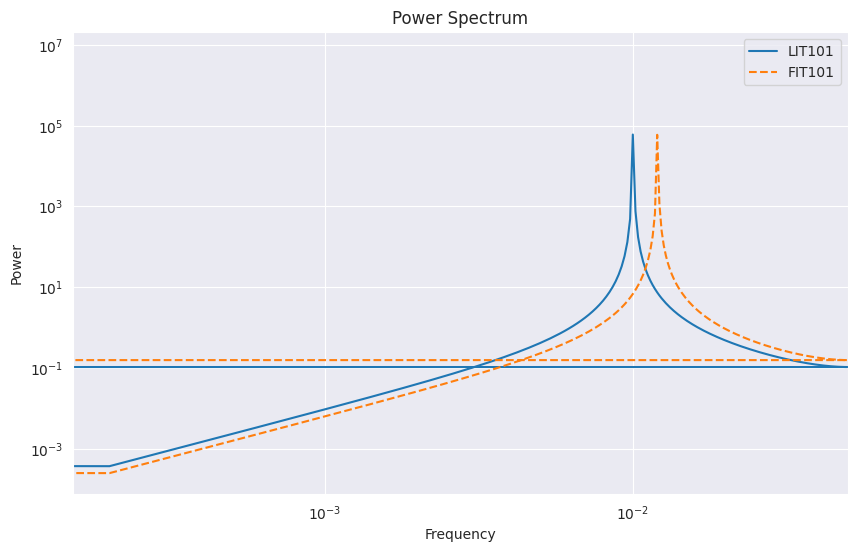

Harmonic Time Differences for LIT101:
Harmonic 2 (0.02) Hz: 50.00000 seconds
Harmonic 3 (0.03) Hz: 33.33333 seconds
Harmonic 4 (0.04) Hz: 25.00000 seconds
Harmonic 5 (0.05) Hz: 20.00000 seconds

Harmonic Time Differences for FIT101:
Harmonic 2 (0.024) Hz: 41.66667 seconds
Harmonic 3 (0.036000000000000004) Hz: 27.77778 seconds
Harmonic 4 (0.048) Hz: 20.83333 seconds
Harmonic 5 (0.06) Hz: 16.66667 seconds


In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def doFourierAnalysis(df, column_name, dt=10.0):
    """
    Perform Fourier analysis on a specified column of a DataFrame and return the frequency bins and power spectrum.

    This function computes the Fast Fourier Transform (FFT) of the data in the specified column,
    calculates the power spectrum, and returns the power spectrum along with the frequency bins.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the data to analyze.
    column_name (str): The name of the column in the DataFrame to analyze.
    dt (float): The time step between data points.

    Returns:
    tuple: A tuple containing the frequency bins and the power spectrum.
    """
    # Extract the data from the DataFrame
    data = df[column_name].values

    # Number of data points
    N = len(data)

    # Compute the Fast Fourier Transform (FFT)
    fft_data = np.fft.fft(data)

    # Compute the Power Spectrum (magnitude of the FFT squared)
    power_spectrum = np.abs(fft_data) ** 2

    # Compute the frequency bins
    freq = np.fft.fftfreq(N, dt)

    return freq, power_spectrum

def get_harmonic_time_differences(df, column_name, dt=10.0):
    """
    Calculate the time differences between peak values of the signal for the harmonics.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the data to analyze.
    column_name (str): The name of the column in the DataFrame to analyze.
    dt (float): The time step between data points.

    Returns:
    dict: A dictionary containing the harmonic frequencies and their corresponding time differences.
    """
    # Perform Fourier analysis
    freq, power_spectrum = doFourierAnalysis(df, column_name, dt)

    # Find the peak frequency (fundamental frequency)
    peak_indices, _ = find_peaks(power_spectrum)
    peak_freq = freq[peak_indices[np.argmax(power_spectrum[peak_indices])]]
    fundamental_period = 1 / peak_freq

    # Identify harmonics
    harmonics = [peak_freq * n for n in range(2, 6)]  # First four harmonics

    # Calculate time differences
    time_differences = {f"Harmonic {n} ({harm}) Hz": fundamental_period / n for n, harm in enumerate(harmonics, start=2)}

    return time_differences

# Sample DataFrame creation for testing
data = {
    'time': np.linspace(0, 1, 500),
    'LIT101': 5 + np.sin(2 * np.pi * 50 * np.linspace(0, 1, 500)),
    'FIT101': 3 + np.sin(2 * np.pi * 60 * np.linspace(0, 1, 500))
}
df_prepped = pd.DataFrame(data)

# Perform Fourier analysis and plot power spectrum
freq_lit101, power_spectrum_lit101 = doFourierAnalysis(df_prepped, 'LIT101')
freq_fit101, power_spectrum_fit101 = doFourierAnalysis(df_prepped, 'FIT101')

plt.figure(figsize=(10, 6))
plt.plot(freq_lit101, power_spectrum_lit101, label='LIT101')
plt.plot(freq_fit101, power_spectrum_fit101, label='FIT101', linestyle='--')
plt.title('Power Spectrum')
plt.xscale('log')
plt.xlabel('Frequency')
plt.yscale('log')
plt.ylabel('Power')
plt.xlim(0, np.max(freq_lit101))  # Limit x-axis to non-negative frequencies
plt.legend()
plt.show()

# Get time differences for harmonics
time_differences_lit101 = get_harmonic_time_differences(df_prepped, 'LIT101')
time_differences_fit101 = get_harmonic_time_differences(df_prepped, 'FIT101')

# Display the results
print("Harmonic Time Differences for LIT101:")
for harmonic, time_diff in time_differences_lit101.items():
    print(f"{harmonic}: {time_diff:.5f} seconds")

print("\nHarmonic Time Differences for FIT101:")
for harmonic, time_diff in time_differences_fit101.items():
    print(f"{harmonic}: {time_diff:.5f} seconds")


In [27]:
def calculate_phase_and_time_difference(df, column1, column2, dt=10.0):
    """
    Calculate the phase difference and time difference between the fundamental frequencies of two signals.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the data to analyze.
    column1 (str): The name of the first column in the DataFrame.
    column2 (str): The name of the second column in the DataFrame.
    dt (float): The time step between data points.

    Returns:
    tuple: A tuple containing the phase difference in radians and the time difference in seconds.
    """
    # Perform Fourier analysis on both columns
    data1 = df[column1].values
    data2 = df[column2].values

    fft_data1 = np.fft.fft(data1)
    fft_data2 = np.fft.fft(data2)

    freq1 = np.fft.fftfreq(len(data1), dt)
    freq2 = np.fft.fftfreq(len(data2), dt)

    # Identify fundamental frequencies
    power_spectrum1 = np.abs(fft_data1) ** 2
    power_spectrum2 = np.abs(fft_data2) ** 2

    peak_indices1, _ = find_peaks(power_spectrum1)
    peak_indices2, _ = find_peaks(power_spectrum2)

    peak_freq1 = freq1[peak_indices1[np.argmax(power_spectrum1[peak_indices1])]]
    peak_freq2 = freq2[peak_indices2[np.argmax(power_spectrum2[peak_indices2])]]

    # Find the corresponding phase at the fundamental frequencies
    phase1 = np.angle(fft_data1[peak_indices1[np.argmax(power_spectrum1[peak_indices1])]])
    phase2 = np.angle(fft_data2[peak_indices2[np.argmax(power_spectrum2[peak_indices2])]])

    # Calculate the phase difference
    phase_difference = phase2 - phase1

    # Calculate the time difference
    avg_freq = (peak_freq1 + peak_freq2) / 2  # Average fundamental frequency
    time_difference = phase_difference / (2 * np.pi * avg_freq)

    return phase_difference, time_difference

# Calculate phase and time difference between LIT101 and FIT101
phase_difference, time_difference = calculate_phase_and_time_difference(df_prepped, 'LIT101', 'FIT101')

# Display the phase difference in radians and the time difference in seconds
print(f"Phase Difference between LIT101 and FIT101: {phase_difference:.5f} radians")
print(f"Time Difference between LIT101 and FIT101: {time_difference:.5f} seconds")


Phase Difference between LIT101 and FIT101: 0.06283 radians
Time Difference between LIT101 and FIT101: 0.90909 seconds


In [28]:
calculate_phase_and_time_difference(df_prepped, 'LIT101', 'FIT101', dt=10.0 )

(0.0628318530717702, 0.9090909090905378)

In [29]:
calculate_phase_and_time_difference(df_prepped, 'FIT101',  'LIT101', dt=10.0 )

(-0.0628318530717702, -0.9090909090905378)